In [ ]:
import pennylane as qml
import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm, trange

Setting of the main hyper-parameters of the model
=================================================


In [3]:
n_epochs = 100   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 1000    # Size of the train dataset
n_test = int(0.6 * n_train)     # Size of the test dataset

SAVE_PATH = "mnist_preprocess/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH

Loading of the MNIST dataset
============================

We import the MNIST dataset from *Keras*. To speedup the evaluation of
this demo we use only a small number of training and test images.
Obviously, better results are achievable when using the full dataset.


In [2]:
def train_sample(train_images, train_labels, n_train):
    train_idxs = np.random.choice(range(len(train_images)), n_train, replace=False)
    return train_images[train_idxs], train_labels[train_idxs]

In [3]:
def test_sample(test_images, test_labels, n_test):
    test_idxs = np.random.choice(range(len(test_images)), n_test, replace=False)
    return test_images[test_idxs], test_labels[test_idxs]

Quantum circuit as a convolution kernel
=======================================

We follow the scheme described in the introduction and represented in
the figure at the top of this demo.

We initialize a PennyLane `default.qubit` device, simulating a system of
$4$ qubits. The associated `qnode` represents the quantum circuit
consisting of:

1.  an embedding layer of local $R_y$ rotations (with angles scaled by a
    factor of $\pi$);
2.  a random circuit of `n_layers`;
3.  a final measurement in the computational basis, estimating $4$
    expectation values.


In [4]:
dev = qml.device("default.qubit", wires=4)

# Random circuit parameters
# rand_params = np.random.uniform(high=2*np.pi, size=(n_layers, 4))
    
@qml.qnode(dev)
def circuit(phi, rand_params):

    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

The next function defines the convolution scheme:

1.  the image is divided into squares of $2 \times 2$ pixels;
2.  each square is processed by the quantum circuit;
3.  the $4$ expectation values are mapped into $4$ different channels of
    a single output pixel.


This process halves the resolution of the input image. In the standard
language of CNN, this would correspond to a convolution with a
$2 \times 2$ *kernel* and a *stride* equal to $2$.

In [6]:
def quanv(image, rand_params):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2x2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ],
                rand_params
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    
    return out

Quantum pre-processing of the dataset
=====================================

Since we are not going to train the quantum convolution layer, it is
more efficient to apply it as a \"pre-processing\" layer to all the
images of our dataset. Later an entirely classical model will be
directly trained and tested on the pre-processed dataset, avoiding
unnecessary repetitions of quantum computations.

The pre-processed images will be saved in the folder `SAVE_PATH`. Once
saved, they can be directly loaded by setting `PREPROCESS = False`,
otherwise the quantum convolution is evaluated at each run of the code.


In [10]:
dataset_name = "fashion"
q_train_images_filename = SAVE_PATH + dataset_name + "_layers_" + str(n_layers) + "_train_" + str(n_train) + "_test_" + str(n_test) + "_q_train_images.npy"
q_test_images_filename = SAVE_PATH + dataset_name + "_layers_" + str(n_layers) + "_train_" + str(n_train) + "_test_" + str(n_test) + "_q_test_images.npy"

if PREPROCESS:
    print("Quantum pre-processing of train images:")
    q_train_images = []
    for idx in trange(len(train_images)):
        img = train_images[idx]
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    print("\nQuantum pre-processing of test images:")
    q_test_images = []
    for idx in trange(len(test_images)):
        img = test_images[idx]
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(q_train_images_filename, q_train_images)
    np.save(q_test_images_filename, q_test_images)


# Load pre-processed images
q_train_images = np.load(q_train_images_filename)
q_test_images = np.load(q_test_images_filename)

Quantum pre-processing of train images:


100%|█████████████████████████████████████████| 150/150 [07:03<00:00,  2.82s/it]



Quantum pre-processing of test images:


100%|███████████████████████████████████████████| 90/90 [04:13<00:00,  2.82s/it]


Let us visualize the effect of the quantum convolution layer on a batch
of samples:


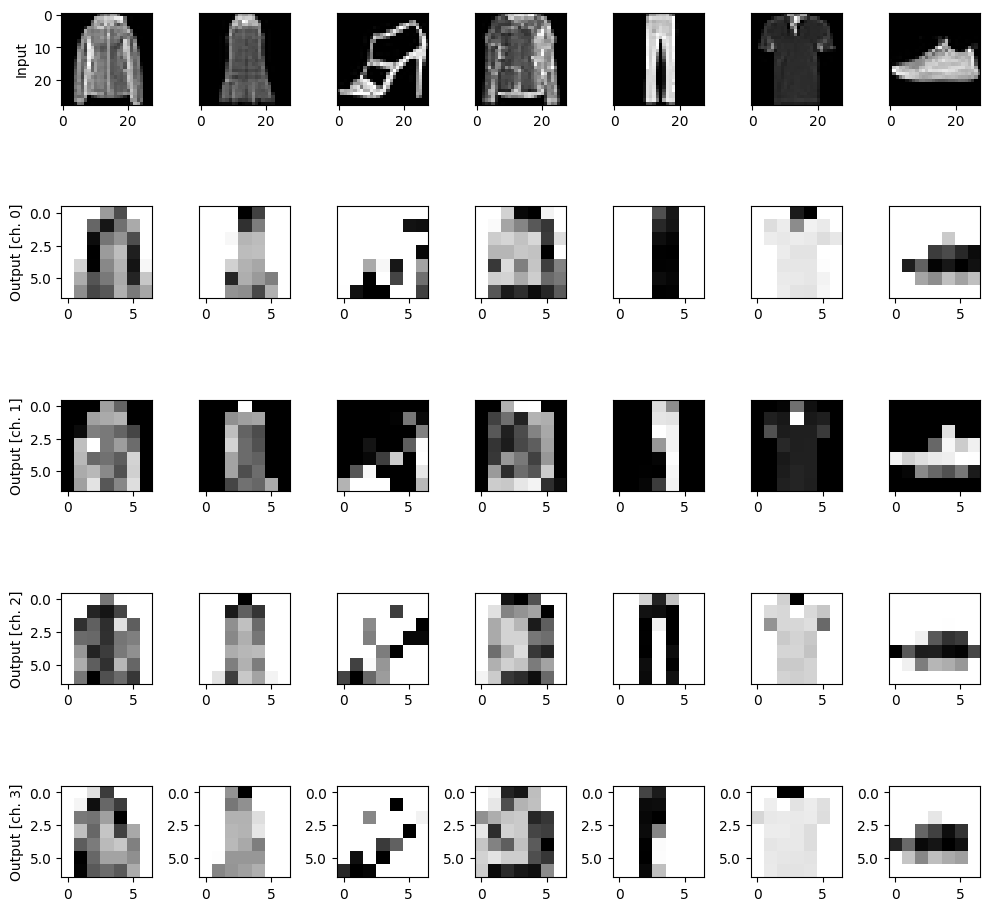

In [11]:
n_samples = 7
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()